# Relative Elevation Model

This tutorial is inspired by [this](https://dancoecarto.com/creating-rems-in-qgis-the-idw-method) blog post, [this](https://wadnr.maps.arcgis.com/apps/Cascade/index.html?appid=36b4887370d141fcbb35392f996c82d9) excellent story map, and [this](https://github.com/DahnJ/REM-xarray/blob/master/rem-in-xarray-tutorial.ipynb) notebook.

In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import opt_einsum as oe
import rasterio
import shapely
import xarray as xr
import xrspatial as xs
from datashader import transfer_functions as tf
from datashader import utils as ds_utils
from datashader.colors import Greys9, inferno
from scipy.spatial import KDTree
from shapely import ops

import py3dep
import pygeoutils as geoutils
import pynhd

Relative Elevation Model (REM) detrends a DEM based on the water surface of a stream. It's especially useful for visualization of floodplains. We're going to compute REM for a segment of Carson River and visualize the results using [xarray-spatial](https://xarray-spatial.org) and [datashader](https://datashader.org).

First, let's check out the available DEM resolutions in our area of interest (AOI).

In [2]:
bbox = (-119.59, 39.24, -119.47, 39.30)
dem_res = py3dep.check_3dep_availability(bbox)
dem_res

{'1m': True,
 '3m': False,
 '5m': False,
 '10m': True,
 '30m': True,
 '60m': False,
 'topobathy': False}

We can see that Lidar (1-m), 10-m, and 30-m are available. Obviously, Lidar data gives us the best results, but it can be computationally expensive. So, we're going to set the resolution to 10 m.

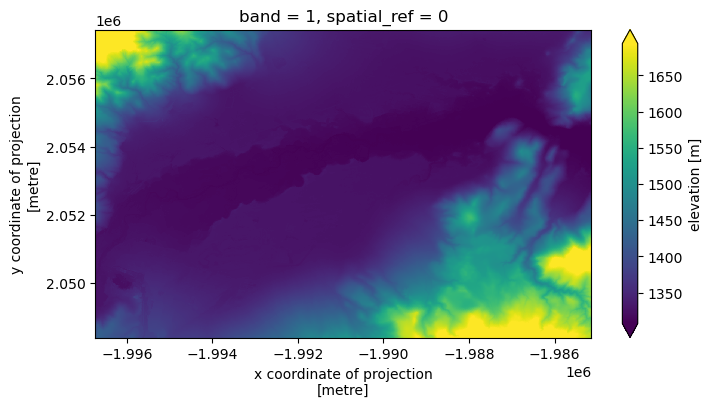

In [3]:
res = 10
dem = py3dep.get_dem(bbox, res)

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
_ = dem.plot(ax=ax, robust=True)

Next, we need to get the river's centerline. For this purpose, first we get the flowlines within our AOI. Then, we remove all the isolated flowlines using the `remove_isolated` flag of `pynhd.prepare_nhdplus` and find the main flowline based on the minimum value of the `levelpathi` attribute.

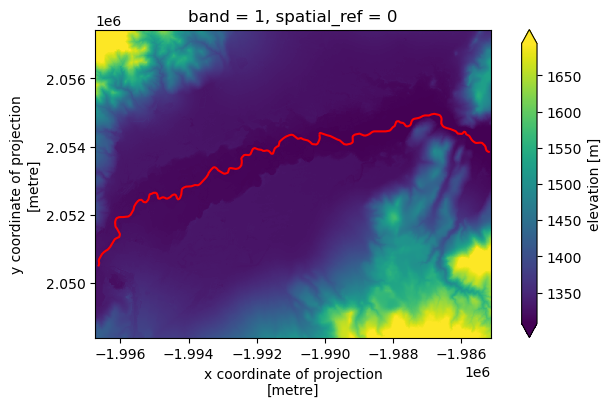

In [4]:
wd = pynhd.WaterData("nhdflowline_network")

flw = wd.bybox(bbox)
flw = pynhd.prepare_nhdplus(flw, 0, 0, 0, remove_isolated=True)
flw = flw[flw.levelpathi == flw.levelpathi.min()].to_crs(dem.rio.crs).copy()

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
flw.plot(ax=ax, color="r")
_ = dem.plot(ax=ax, robust=True)

Now, we can get the elevation profile along the obtained main flowline with spacing of 10 meters. FOr this purpose, first, we we use [PyGeoUtils](https://docs.hyriver.io/readme/pygeoutils.html) to smooth the river flowline at 10 m spacing. Then, we use the smoothed flowline to get the elevation profile from USGS's 10-m DEM. PyGeoUtils has a function for efficiently sampling a raster file at points for a give window size (5 by default) and resampling method (bilinear by default).

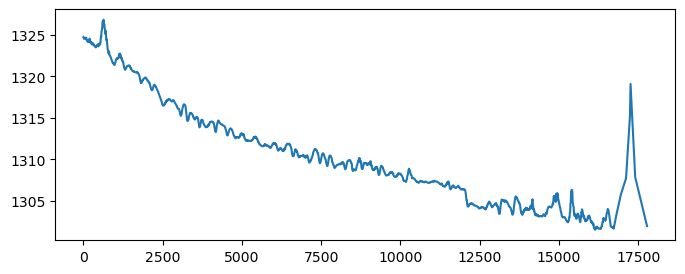

In [5]:
river_line = ops.linemerge(flw.geometry.tolist())
npts = int(np.ceil(river_line.length / 10))
river_line = geoutils.smooth_linestring(river_line, 0.1, npts)

url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/USGS_Seamless_DEM_13.vrt"
with rasterio.open(url) as src:
    xy = shapely.get_coordinates(geoutils.geo_transform(river_line, flw.crs, src.crs))
    z = np.ravel(list(geoutils.sample_window(src, xy)))
    river_elev = np.c_[shapely.get_coordinates(river_line), z]

distances = shapely.line_locate_point(river_line, shapely.points(river_line.coords))
plt.figure(figsize=(8, 3), dpi=100)
_ = plt.plot(distances, river_elev[:, 2])

There are several methods for detrending the DEM based on the river's elevation profile. You can check these method in [this](https://www.dnr.wa.gov/publications/ger_presentations_dmt_2016_coe.pdf) poster. Here, we're going to use Inverse Distance Weighting method using `scipy`'s `KDTree` function and setting the number of neighbors to 200.

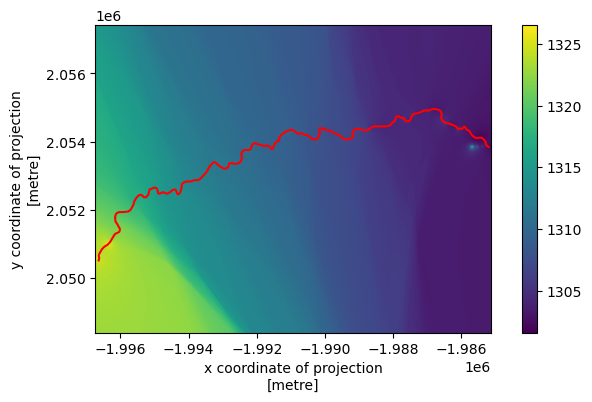

In [6]:
distances, idxs = KDTree(river_elev[:, :2]).query(
    np.dstack(np.meshgrid(dem.x, dem.y)).reshape(-1, 2),
    k=200,
    workers=-1,
)

w = np.reciprocal(np.power(distances, 2) + np.isclose(distances, 0))
w_sum = np.sum(w, axis=1)
w_norm = oe.contract("ij,i->ij", w, np.reciprocal(w_sum + np.isclose(w_sum, 0)), optimize="optimal")
elevation = oe.contract("ij,ij->i", w_norm, river_elev[idxs, 2], optimize="optimal")
elevation = elevation.reshape((dem.sizes["y"], dem.sizes["x"]))
elevation = xr.DataArray(elevation, dims=("y", "x"), coords={"x": dem.x, "y": dem.y})
rem = dem - elevation

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
elevation.plot(ax=ax)
_ = flw.plot(ax=ax, color="red")

Let's use datashader to stack DEM, Hillshade and REM for a nice visualization. There are a couple of parameters in this tutorial that can be change for extending it to other regions: Number of neighbors in IDW, DEM resolution, `span` argument of REM's shading operation.

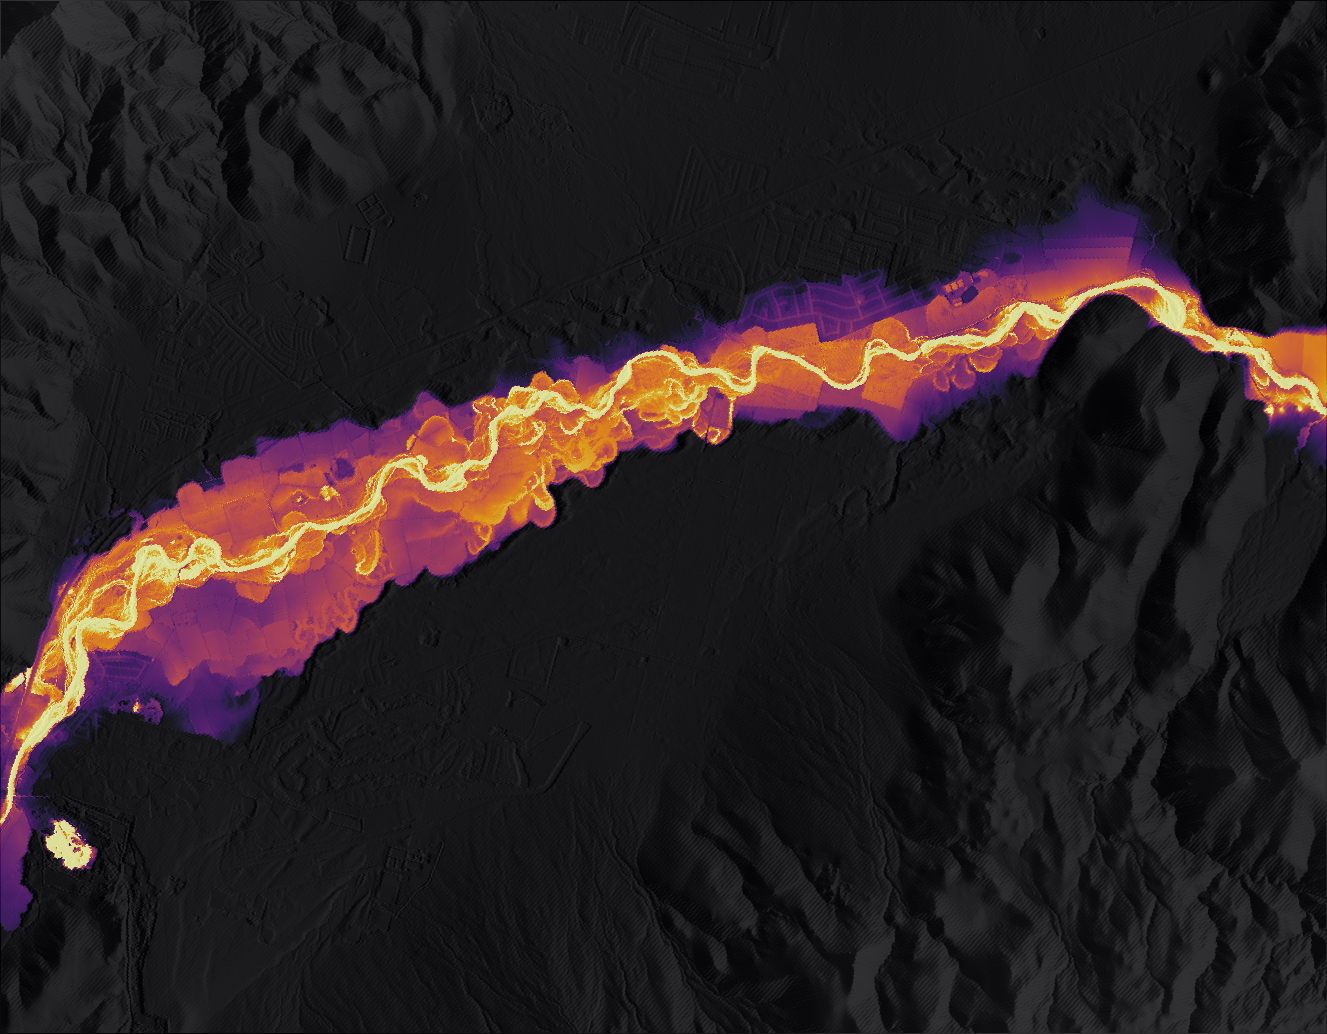

In [7]:
illuminated = xs.hillshade(dem, angle_altitude=10, azimuth=90)
tf.Image.border = 0
img = tf.stack(
    tf.shade(dem, cmap=Greys9, how="linear"),
    tf.shade(illuminated, cmap=["black", "white"], how="linear", alpha=180),
    tf.shade(rem, cmap=inferno[::-1], span=[0, 7], how="log", alpha=200),
)
ds_utils.export_image(img[::-1], Path("_static", "rem").as_posix())